<a href="https://colab.research.google.com/github/machine-perception-robotics-group/MPRGDeepLearningLectureNotebook/blob/master/15_gcn/05_graph_generation_DGMG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# グラフ生成

---



グラフ生成とは,その名の通りグラフを生成する分野です.  
最も一般的なタスクは, 化合物の生成です.  
化合物の性質（水溶性,毒性...）を考慮しながら生成することで, 創薬研究などに役立ちます.

グラフ構造を考慮できるGCNの発展に伴い,グラフ生成分野も研究が進みました.  
グラフ生成にも色々なアプローチがありますが,ここではDGMGという手法について紹介します.  
画像生成では出来ない,グラフ特有の生成の仕方なので面白いと思います.

#Learning Deep Generative Models of Graphs (DGMG) [[arXiv](https://arxiv.org/pdf/1803.03324.pdf)]

---



DGMGは3つの識別器と,生成フローを組み合わせることでグラフを生成する手法です.  

3つの識別器
- add node：新しいノードを追加　or 追加しない (生成フロー終了)
- add edge：新しいノードにエッジを追加 or 追加しない
- choose dest：新しいノードと，どのノードにエッジを追加するのかの識別器

以下が, ３つの識別器を使った生成フローです.

<!--
<img src='https://drive.google.com/uc?id=1meLvQov6EbRnCZ8mSGvGaBeo_gjrWPk4' width=70%>
-->
<!--
<img src='https://github.com/machine-perception-robotics-group/MPRGDeepLearningLectureNotebook/blob/master/15_gcn/fig/05_graph_flow.png?raw=true' width=70%>
-->
<img src='https://github.com/sirakik/MPRGLecture/blob/master/15_gcn/fig/05_graph_flow.png?raw=true' width=70%>

3つのノードを持つグラフの生成過程の例が下の画像です.  
生成フロー通りに, 識別器が動いているのが，分かると思います.

ここで，各識別器の出力を並べると``[0100010000111]``のようなシーケンスとして表現することが出来ます.  
DGMGはこのシーケンスを教師として学習を行います.  
DGMGはグラフの形そのものを学習するのではなく, そのグラフにたどり着くための識別器の出力順を学習します.

<!--
<img src='https://drive.google.com/uc?id=1dgpk8kVBcOB1eJSKwwcxirvGeb6wI9bn' width=70%>
-->
<!--
<img src='https://github.com/machine-perception-robotics-group/MPRGDeepLearningLectureNotebook/blob/master/15_gcn/fig/05_flow.png?raw=true' width=70%>
-->
<img src='https://github.com/sirakik/MPRGLecture/blob/master/15_gcn/fig/05_flow.png?raw=true' width=70%>

# 前準備

必要なモジュールをインストール, インポートします.

In [ ]:
pip install dgl  \
pip install networkx

     |████████████████████████████████| 3.5MB 2.7MB/s 


In [ ]:
import numpy as np
import pickle
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
from torch.distributions import Bernoulli, Categorical
import dgl
from dgl.data import MiniGCDataset
from dgl.nn.pytorch import GraphConv
import networkx as nx
import matplotlib.pyplot as plt

DGL backend not selected or invalid.  Assuming PyTorch for now.
Using backend: pytorch


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


# データセット　(MiniGCDataset)

---



生成される化合物を直感的に評価することが難しいので,ここでは簡単なグラフ構造の生成を試みます.  
DGLが提供する, MiniGCDatasetを利用します.  
MiniGCDatasetは, 8クラスのグラフ構造があり, クラスごとにノード数が異なるグラフを持ちます.

<!--
<img src='https://drive.google.com/uc?id=1ALGAgXLqRAKbZ20oXFKYtmZYWjTn99Zv' width=80%>
-->
<!--
<img src='https://github.com/machine-perception-robotics-group/MPRGDeepLearningLectureNotebook/blob/master/15_gcn/fig/05_dataset_overview.png?raw=true' width=80%>
-->
<img src='https://github.com/sirakik/MPRGLecture/blob/master/15_gcn/fig/05_dataset_overview.png?raw=true' width=80%>


[引用元：https://docs.dgl.ai/en/0.4.x/tutorials/basics/4_batch.html]

MiniGCDatasetはデータセットではあるものの，データ数や，ノード数を自由に設定し，作成することができます.

In [ ]:
num_per_graph = 100 # クラスごとのデータ数
min_num_node = 10 # 生成されるグラフの最小ノード数
max_num_node = 20 # 生成されるグラフの最大ノード数
dataset = MiniGCDataset(num_per_graph*8, min_num_node, max_num_node)

データを可視化してみます.データはクラスごとに並んでいます.  
クラスごとのデータ数を100にした場合, 0\~99がクラス0, 100\~199がクラス1のようになっています.  
``DATA_INDEX``を編集して，可視化してみてください.  
最小，最大ノード数内でグラフが生成されています.

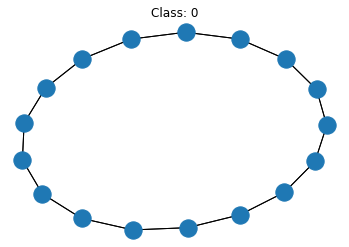

In [ ]:
DATA_INDEX = 10

graph, label = dataset[DATA_INDEX]
fig, ax = plt.subplots()
nx.draw(graph.to_networkx(), ax=ax, arrows=False)
ax.set_title('Class: {:d}'.format(label))
plt.show()

### グラフをシーケンスに変換


DGMGの教師となるシーケンスを作成します.  
``adj_to_sequence``関数によって,グラフの隣接行列からシーケンスを作成しています.  
また，学習するクラスを変更する実験をするため，シーケンスを生成する手順を関数化しておき, 学習の直前で教師を作成します.

In [ ]:
def adj_to_sequence(adj):
    sequence = []
    for node in range(len(adj)):
        sequence.append(0)  # add node
        for dest in range(node):
            if adj[node][dest] == 1:
                sequence.append(0)  # add edge
                sequence.append(dest)  # add dest node
        sequence.append(1)  # stop add edge
    sequence.append(1)  # stop add node
    return sequence

def make_dataset(class_label):
    list_sequence = []
    for cla in class_label:
        s_index = cla * num_per_graph
        for index in range(s_index, s_index+num_per_graph):
            graph, _ = dataset[index]
            tril = np.ones((graph.number_of_nodes(), graph.number_of_nodes()))
            tril = np.tril(tril, k=-1)
            adj = graph.adjacency_matrix().to_dense().numpy()
            adj = tril*adj
            sequence = adj_to_sequence(adj)
            list_sequence.append(sequence)
    with open('sequence_data.p', 'wb') as f:
        pickle.dump(list_sequence, f)

データを読み込む関数です.

In [ ]:
class MiniGCDataset(torch.utils.data.Dataset):
    def __init__(self, fname='sequence_data.p'):
        super(MiniGCDataset, self).__init__()
        with open(fname, 'rb') as f:
            self.data = pickle.load(f)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index]

# DGMG実装

---



### graph embedding

add nodeやadd edgeの識別器（全結合層）に渡すために, グラフ特徴を埋め込み表現にする役割です.　　

\begin{equation}
{\bf h}_{G}=\sum_{n\in \bf V} f_e({\bf h}_v) \odot sigmoid(g_e({\bf h}_v))
\end{equation}

$f_e(\cdot),g_e(\cdot)$は全結合層です.重要なノードを考慮しつつ特徴を埋め込みます.

<!--
<img src='https://drive.google.com/uc?id=1fBUApZyGIHXUbWG6lVTYKt9gwDSevtxV' width=40%>
-->
<!--
<img src='https://github.com/machine-perception-robotics-group/MPRGDeepLearningLectureNotebook/blob/master/15_gcn/fig/05_embed.png?raw=true' width=40%>
-->
<img src='https://github.com/sirakik/MPRGLecture/blob/master/15_gcn/fig/05_graph_embed.png?raw=true' width=40%>

In [ ]:
class GraphEmbed(nn.Module):
    def __init__(self, node_hidden_size):
        super(GraphEmbed, self).__init__()
        self.graph_hidden_size = 2 * node_hidden_size
        self.node_gating = nn.Sequential(
            nn.Linear(node_hidden_size, 1),
            nn.Sigmoid())
        self.node_to_graph = nn.Linear(node_hidden_size,
                                       self.graph_hidden_size)

    def forward(self, g):
        # ノード数が0(生成の最初)のときは空の特徴を返します.
        if g.number_of_nodes() == 0:
            return torch.zeros(1, self.graph_hidden_size)
        else:
            hvs = g.ndata['hv']
            hvs = (self.node_gating(hvs) * self.node_to_graph(hvs)).sum(0, keepdim=True)
            return hvs

### feature extractor

feature extractorは生成フロー中で,エッジが追加された後に使用され,現状のグラフ構造を理解します.  
DGMGでは特徴抽出器としてGGNN(GRUを使ったノード特徴集約手法)を使っています.  
Graph convolutionより少しだけ前の手法であり, GRUを利用するため勾配消失・爆発が起こりやすい特徴もあります.  
せっかくなのでGraph convolutionに変更してみます.  
今回は,DGLに実装されている``GraphConv``関数を利用します.

<!--
<img src='https://drive.google.com/uc?id=12NPl3B8skdJ3qsZXwKiotlgFB94gCv1v' width=40%>
-->
<!--
<img src='https://github.com/machine-perception-robotics-group/MPRGDeepLearningLectureNotebook/blob/master/15_gcn/fig/05_DGMG_feature_extractor.png?raw=true' width=40%>
-->
<img src='https://github.com/sirakik/MPRGLecture/blob/master/15_gcn/fig/05_DGMG_feature_extractor.png?raw=true' width=40%>

In [ ]:
class FeatureExtractor(nn.Module):
    def __init__(self, num_hidden_size):
        super(FeatureExtractor, self).__init__()
        self.gc1 = GraphConv(num_hidden_size, 2 * num_hidden_size)
        self.gc2 = GraphConv(2 * num_hidden_size, num_hidden_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, g):
        if g.number_of_edges() == 0:
            return g
        else:
            h = self.gc1(g, g.ndata['hv'])
            h = self.sigmoid(h)
            g.ndata['hv'] = self.gc2(g, h)
            return g

### add node

グラフに新しいノードを追加するか, しないかの2クラス分類器です.  
graph embedを通り, その出力値をadd node(全結合層)に通します.  
化合物生成の場合, 新しいノード(原子)のクラス(H, He, Li, Be...)を予測する必要がありますが,ここでは必要ありません.  
クラスではなく, 新しいノード特徴を生成するのみです(``itinialize_node``).

<!--
<img src='https://drive.google.com/uc?id=1pK1QNLiaF7qHFMBXS6rbmm94glgUpGND' width=60%>
-->
<!--
<img src='https://github.com/machine-perception-robotics-group/MPRGDeepLearningLectureNotebook/blob/master/15_gcn/fig/05_graph_embed_add_node.png?raw=true' width=60%>
-->
<img src='https://github.com/sirakik/MPRGLecture/blob/master/15_gcn/fig/05_graph_embed_add_node.png?raw=true' width=60%>

In [ ]:
class AddNode(nn.Module):
    def __init__(self, graph_embed, node_hidden_size):
        super(AddNode, self).__init__()
        self.graph_embed = graph_embed
        self.add_node = nn.Linear(graph_embed.graph_hidden_size, 1)
        self.sigmoid = nn.Sigmoid()
        # initialize node
        self.node_embed = nn.Embedding(1, node_hidden_size)
        self.initialize_hv = nn.Linear(graph_embed.graph_hidden_size, node_hidden_size)
        self.activation_node = torch.zeros(1, 2 * node_hidden_size)

    def prepare_training(self):
        self.log_prob = 0

    def initialize_node(self, g, graph_feature):
        last_node = g.number_of_nodes() - 1
        hv_init = self.initialize_hv(graph_feature)
        g.nodes[last_node].data['hv'] = hv_init
        g.nodes[last_node].data['a'] = self.activation_node
        return g

    def bernoulli_action_prob(self, logit, action):
        if action == 0:
            return F.logsigmoid(-logit)
        else:
            return F.logsigmoid(logit)

    def forward(self, g, action=None):
        graph_feature = self.graph_embed(g)
        logit = self.add_node(graph_feature)

        if self.training:
            self.log_prob += self.bernoulli_action_prob(logit, action)
        else:
            prob = self.sigmoid(logit)
            action = Bernoulli(prob).sample().item()

        stop = bool(action == 1)  # 1はstop

        if not stop:
            g.add_nodes(1)
            g = self.initialize_node(g, graph_feature)

        return g, stop

### add edge

新しいノードにエッジを追加するか, しないかの2クラス分類器です.  
新しくノードが追加されたため, グラフの埋め込みをもう一度行います.  
埋め込み表現された特徴に, 新しいノード特徴を結合しadd edge(全結合層)に通します.

<!--
<img src='https://drive.google.com/uc?id=16iALJ82t-1QydVsYwWTnyjwgrXdO3zHK' width=60%>
-->
<!--
<img src='https://github.com/machine-perception-robotics-group/MPRGDeepLearningLectureNotebook/blob/master/15_gcn/fig/05_graph_embed_add_edge.png?raw=true' width=60%>
-->
<img src='https://github.com/sirakik/MPRGLecture/blob/master/15_gcn/fig/05_graph_embed_add_edge.png?raw=true' width=60%>

In [ ]:
class AddEdge(nn.Module):
    def __init__(self, graph_embed, node_hidden_size):
        super(AddEdge, self).__init__()
        self.graph_embed = graph_embed
        self.add_edge = nn.Linear(graph_embed.graph_hidden_size + node_hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def prepare_training(self):
        self.log_prob = 0

    def bernoulli_action_prob(self, logit, action):
        if action == 0:
            return F.logsigmoid(-logit)
        else:
            return F.logsigmoid(logit)

    def forward(self, g, action=None):
        graph_feature = self.graph_embed(g)
        last_node_feature = g.nodes[g.number_of_nodes() - 1].data['hv']
        logit = self.add_edge(torch.cat([graph_feature, last_node_feature], dim=1))

        if self.training:
            self.log_prob += self.bernoulli_action_prob(logit, action)
        else:
            prob = self.sigmoid(logit)
            action = Bernoulli(prob).sample().item()

        to_add_edge = bool(action == 0)

        return to_add_edge

### choose dest

add edgeによって,エッジを追加すると判断された場合に,どのノードにエッジを追加するかを決める多クラス分類器です.  
エッジが追加された後に,feature extractorに通します.

<!--
<img src='https://drive.google.com/uc?id=14_6edweMFguIJenWQ18xciHg3zg5gcsD' width=70%>
-->
<!--
<img src='https://github.com/machine-perception-robotics-group/MPRGDeepLearningLectureNotebook/blob/master/15_gcn/fig/05_choose_dest_feature_extractor.png?raw=true' width=70%>
-->
<img src='https://github.com/sirakik/MPRGLecture/blob/master/15_gcn/fig/05_choose_dest_feature_extractor.png?raw=true' width=70%>

In [ ]:
class ChooseDest(nn.Module):
    def __init__(self, graph_prop, node_hidden_size):
        super(ChooseDest, self).__init__()
        self.graph_prop = graph_prop
        self.choose_dest = nn.Linear(2 * node_hidden_size, 1)
        self.softmax = nn.Softmax(dim=1)

    def prepare_training(self):
        self.log_prob = 0

    def initialize_edge(self, g, src_list, dest_list):
        edge_repr = torch.ones(len(src_list), 1)
        g.edges[src_list, dest_list].data['he'] = edge_repr
        return g

    def forward(self, g, dest=None):
        last_node = g.number_of_nodes() - 1
        possible_dest = range(last_node)

        last_node_feature_expand = g.nodes[last_node].data['hv'].expand(last_node, -1)
        possible_dest_feature = g.nodes[possible_dest].data['hv']

        dest_score = self.choose_dest(
            torch.cat([possible_dest_feature, last_node_feature_expand], dim=-1
        )).view(1, -1)
        dest_prob = self.softmax(dest_score)

        if self.training:
            dest = int(dest.item())
            if dest_prob.nelement() > 1:
                self.log_prob += F.log_softmax(dest_score, dim=1)[:, dest:dest+1]
        else:
            dest = Categorical(dest_prob).sample().item()

        if not g.has_edges_between(last_node, dest):
            src_list = [last_node, dest]
            dest_list = [dest, last_node]
            g.add_edges(src_list, dest_list)
            g = self.initialize_edge(g, src_list, dest_list)
        g = self.graph_prop(g)
        return g

### DGMG

生成フローを定義しています.  
学習時は，シーケンス（真値）を与え,グラフ生成をします.  
仮に,識別器の答えが真値と違った場合でも,真値が出力されたと仮定して,生成を続けます. 

<!--
<img src='https://drive.google.com/uc?id=1meLvQov6EbRnCZ8mSGvGaBeo_gjrWPk4' width=70%>
-->
<!--
<img src='https://github.com/machine-perception-robotics-group/MPRGDeepLearningLectureNotebook/blob/master/15_gcn/fig/05_graph_flow.png?raw=true' width=70%>
-->
<img src='https://github.com/sirakik/MPRGLecture/blob/master/15_gcn/fig/05_graph_flow.png?raw=true' width=70%>

In [ ]:
def weights_init(m):
    if isinstance(m, nn.Linear):
        init.xavier_normal_(m.weight.data)
        init.normal_(m.bias.data)
    elif isinstance(m, nn.GRUCell):
        for param in m.parameters():
            if len(param.shape) >= 2:
                init.orthogonal_(param.data)
            else:
                init.normal_(param.data)

class DGMG(nn.Module):
    def __init__(self, max_num_node, node_hidden_size):
        super(DGMG, self).__init__()
        self.max_num_node = max_num_node
        self.graph_embed = GraphEmbed(node_hidden_size)
        self.graph_prop = FeatureExtractor(node_hidden_size)
        self.add_node = AddNode(self.graph_embed, node_hidden_size)
        self.add_edge = AddEdge(self.graph_embed, node_hidden_size)
        self.choose_dest = ChooseDest(self.graph_prop, node_hidden_size)
        self.init_weight()

    def init_weight(self):
        self.graph_embed.apply(weights_init)
        self.graph_prop.apply(weights_init)
        self.add_node.apply(weights_init)
        self.add_edge.apply(weights_init)
        self.choose_dest.apply(weights_init)

    @property
    def action_step(self):
        last_step_count = self.step_count
        self.step_count += 1
        return last_step_count

    def prepare_for_train(self):
        self.step_count = 0
        self.add_node.prepare_training()
        self.add_edge.prepare_training()
        self.choose_dest.prepare_training()

    def get_log_prob(self):
        return self.add_node.log_prob + self.add_edge.log_prob + self.choose_dest.log_prob

    def forward_train(self, sequence):
        self.prepare_for_train()
        self.g, stop = self.add_node(self.g, sequence[self.action_step])
        while not stop:
            to_add_edge = self.add_edge(self.g, sequence[self.action_step])
            while to_add_edge:
                self.g = self.choose_dest(self.g, sequence[self.action_step])
                to_add_edge = self.add_edge(self.g, sequence[self.action_step])
            self.g, stop = self.add_node(self.g, sequence[self.action_step])
        return self.get_log_prob()

    def forward_eval(self):
        self.g, stop = self.add_node(self.g)
        while (not stop) and (self.g.number_of_nodes() < self.max_num_node + 1):
            num_dest = 0
            to_add_edge = self.add_edge(self.g)
            while to_add_edge and (num_dest < self.g.number_of_nodes() - 1):
                self.g = self.choose_dest(self.g)
                num_dest += 1
                to_add_edge = self.add_edge(self.g)
            self.g, stop = self.add_node(self.g)
        return self.g

    def forward(self, sequence=None):
        self.g = dgl.DGLGraph()
        self.g.set_n_initializer(dgl.frame.zero_initializer)
        self.g.set_e_initializer(dgl.frame.zero_initializer)
        if self.training:
            return self.forward_train(sequence)
        else:
            return self.forward_eval()  

# 学習

---



各識別器のアクション$a_1,\dots,a_T$は,以下のように確率として表現できます.

\begin{equation}
p(a_1,\dots,a_T)=p(a_1)p(a_2|a_1)\dots p(a_T|a_1,\dots,a_{T-1})
\end{equation}

この確率をパラメータの関数と見なすことができるので,  
MLE　Loss(Maximum Likelihood Estimation:最尤推定)によってモデルを最適化させます.

\begin{equation}
E = -\log p(a_1,\dots,a_T) = -\sum^T_t \log p(a_t|a_1,\dots,a_{t-1})
\end{equation}

また, 学習させるグラフクラスを選択することができます.  
``make_dataset(class_label=[])``の配列にグラフラベルを入力してください.  
複数のグラフを学習させることもできます.  
複数のグラフを学習させた場合,　各グラフの特徴を考慮したグラフが生成されるはずです.

In [ ]:
NUM_EPOCH = 100
BATCH_SIZE = 32

# クラスの選択
make_dataset(class_label=[2])

# data loaderのバッチサイズは1で固定です
data_loader = torch.utils.data.DataLoader(MiniGCDataset(),
                                          batch_size=1,
                                          shuffle=True)

model = DGMG(max_num_node,
                node_hidden_size=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

#model.train()
for epoch in range(1, NUM_EPOCH+1):
    batch_count = 0
    batch_loss = 0
    optimizer.zero_grad()
    for i, data in enumerate(data_loader):
        data = data
        log_prob = model(sequence=data)
        prob = log_prob.detach().exp()

        loss = - log_prob / BATCH_SIZE
        loss.backward()
        batch_loss += loss.item()
        batch_count += 1

        if batch_count % BATCH_SIZE == 0:
            optimizer.step()
            optimizer.zero_grad()
            print('# Epoch: {} | Batch: [{}/{}] | loss: {:.4f}'.format(epoch, i+1, len(data_loader), batch_loss/BATCH_SIZE))
            batch_loss = 0

/usr/local/lib/python3.6/dist-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)


# Epoch: 1 | Batch: [32/100] | loss: 3.5780
# Epoch: 1 | Batch: [64/100] | loss: 2.6063
# Epoch: 1 | Batch: [96/100] | loss: 2.7195
# Epoch: 2 | Batch: [32/100] | loss: 2.4547
# Epoch: 2 | Batch: [64/100] | loss: 2.7702
# Epoch: 2 | Batch: [96/100] | loss: 2.4727
# Epoch: 3 | Batch: [32/100] | loss: 2.4718
# Epoch: 3 | Batch: [64/100] | loss: 2.4352
# Epoch: 3 | Batch: [96/100] | loss: 2.3096
# Epoch: 4 | Batch: [32/100] | loss: 2.5930
# Epoch: 4 | Batch: [64/100] | loss: 2.3109
# Epoch: 4 | Batch: [96/100] | loss: 2.2435
# Epoch: 5 | Batch: [32/100] | loss: 2.4525
# Epoch: 5 | Batch: [64/100] | loss: 2.3655
# Epoch: 5 | Batch: [96/100] | loss: 2.2355
# Epoch: 6 | Batch: [32/100] | loss: 2.3511
# Epoch: 6 | Batch: [64/100] | loss: 2.3058
# Epoch: 6 | Batch: [96/100] | loss: 2.2887
# Epoch: 7 | Batch: [32/100] | loss: 2.1249
# Epoch: 7 | Batch: [64/100] | loss: 2.3566
# Epoch: 7 | Batch: [96/100] | loss: 2.1518
# Epoch: 8 | Batch: [32/100] | loss: 2.2265
# Epoch: 8 | Batch: [64/100] | l

# 可視化

---



生成されるグラフを数値として評価することは困難なので,可視化することで評価します.  
何回も生成してみてください．毎回違うグラフが生成されるはずです.

/usr/local/lib/python3.6/dist-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)


ノードの数   :　 9
エッジの本数　：　 30


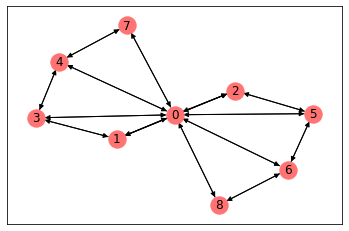

In [ ]:
model.eval()
g = model()

print('ノードの数   :　', g.number_of_nodes())
print('エッジの本数　：　', g.number_of_edges())
nx.draw_networkx(g.to_networkx(), node_color=[[1.0, 0.45, 0.45]])
plt.show()